**Dataset Reference:**

https://github.com/PyThaiNLP/wisesight-sentiment

Arthit Suriyawongkul, Ekapol Chuangsuwanich, Pattarawat Chormai, and Charin Polpanumas. 2019. PyThaiNLP/wisesight-sentiment: First release. September.

# Setup

Download ไฟล์ข้อมูล csv (Comma-Separated Value)

In [6]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [8]:
!gdown 1hdR3HNcU77iBu5wHEHdW3IvDtBZeAnNZ

Downloading...
From: https://drive.google.com/uc?id=1hdR3HNcU77iBu5wHEHdW3IvDtBZeAnNZ
To: /content/Overall_Corpus.csv
100% 169k/169k [00:00<00:00, 130MB/s]


ติดตั้ง Library ที่จำเป็นสำหรับการประมวลผลภาษาธรรมชาติที่เป็นภาษาไทย

*   https://pythainlp.github.io

*   https://pypi.org/project/pythainlp

In [9]:
!pip install pythainlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 67.6 MB/s eta 0:00:00


import Library และ Function ที่จำเป็น

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import re
import string
from pythainlp.corpus.common import thai_stopwords
from pythainlp import word_tokenize
from pythainlp.util import normalize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# สร้าง list ของคำหยุด (Stop words) ภาษาไทย
th_stopwords = list(thai_stopwords())

สร้างฟังก์ชันที่นำผลการทำนายมาเปรียบเทียบกับผลเฉลย นำมาคำนวณ Accuracy Score และแสดง confusion matrix

In [1]:
def showConfisionMatrix(label, predict):
  cm = confusion_matrix(label, predict)
  ac = accuracy_score(label, predict)
  print("Accuracy score: {:.4f}".format(ac))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "neu", "pos"])
  fig, ax = plt.subplots(figsize=(8,8))
  disp.plot(ax=ax, values_format=",d")

# Load Data

*   อ่านไฟล์ข้อมูล csv โดยใช้ Library Pandas
*   ตรวจสอบขนาดของไฟล์ข้อมูล
*   ตรวจสอบลักษณะของข้อมูลเบื้องต้น



In [6]:
df = pd.read_csv("Corpus_after_remove_question_clean.csv", usecols=["textDisplay", "Overview sentiment"]);
df = df.dropna()
print("Dataset contains {:,} rows {} columns".format(df.shape[0], df.shape[1]))
df.head()

Dataset contains 1,530 rows 2 columns


,textDisplay,Overview sentiment
0,ชอบกล้อง กับ ตัดต่อวีดีโอแค่นั้นแหละถ้าจะซื้อไ...,pos
1,คุณภาพแบตลดไป 3% เหลือ 97%ถ้าหมดไป1ปี,neu
2,มันควรปล่อย 120hz ได้แล้ว,neu
3,กำลังจะตัดสินใจซื้อ 14 แต่พอจอ 60 บายเลยค่ะ,neg
4,แบตเตอรี่โอเค,pos


**Question:** จะตรวจสอบ "ชนิดของข้อมูลที่นำเข้า" ได้ด้วยวิธีการใด

In [3]:
# ==== You Code Here ====
type(df)

pandas.core.frame.DataFrame

**Code it:** ใช้ function value_counts() เพื่อตรวจสอบว่าข้อมูลที่นำเข้ามา แต่ละ class มีจำนวนเท่าไร

In [4]:
# ==== Expected Result ====

In [7]:
# ==== You Code Here ====
df["Overview sentiment"].value_counts()

neu    613
neg    471
pos    446
Name: Overview sentiment, dtype: int64

สามารถสร้างกราฟง่าย ๆ เพื่อเปรียบเทียบจำนวนของข้อมูลในแต่ละ class

In [ ]:
# ==== Expected Result ====

<AxesSubplot:>

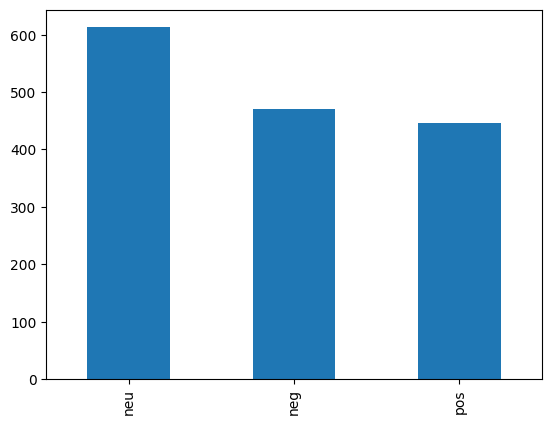

In [8]:
# ==== Revise code ====
df["Overview sentiment"].value_counts().plot.bar()

# Preprocessing Text Data

ทำความสะอาดข้อมูลเบื้องต้น

เนื่องจากข้อมูลที่มี อยู่ในลักษณะของข้อความภาษาไทย จึงวางแผนการทำความสะอาดข้อมูล ดังนี้

*   ลบตัวเลขออก และแทนค่าด้วยช่องว่าง 1 ช่อง
*   ลบเครื่องหมายวรรคตอนออกจากประโยค
*   ตัดคำด้วย function word_tokenize จาก Library PyThaiNLP
*   ลบ Stop words ออกจากประโยค
*   เชื่อมคำที่ถูกตัดแล้ว ให้คั่นด้วยเครื่องหมาย "|"

Series.str.translate(table)

Map all characters in the string through the given mapping table

str.maketrans()

returns a mapping table

In [ ]:
# ==== Expected Result ====

In [9]:
def text_cleansing(sentence):
  # sentence = re.sub(r'[0-9]+', ' ', sentence)
  sentence = re.sub(r'\s+', ' ', sentence)
  sentence = sentence.translate(str.maketrans(dict.fromkeys(string.punctuation)))
  # sentence = normalize(sentence)

  # ==== Revise code ==== ตัดคำจากข้อความให้เป็น list
  tokens = word_tokenize(sentence, keep_whitespace=False)

  # ==== Revise code ==== นำคำที่เป็นคำหยุดออกจาก list คำที่ตัดแล้ว
  # tokens = [word for word in tokens if word not in th_stopwords]

  # ==== Revise code ==== เชื่อมคำใน list ด้วยเครื่องหมาย "|"
  return '|'.join(tokens)


df['tokenize'] = df['textDisplay'].apply(text_cleansing)
df.head()

,textDisplay,Overview sentiment,tokenize
0,ชอบกล้อง กับ ตัดต่อวีดีโอแค่นั้นแหละถ้าจะซื้อไ...,pos,ชอบ|กล้อง|กับ|ตัดต่อ|วีดีโอ|แค่|นั้นแหละ|ถ้า|จ...
1,คุณภาพแบตลดไป 3% เหลือ 97%ถ้าหมดไป1ปี,neu,คุณภาพ|แบต|ลด|ไป|3|เหลือ|97|ถ้า|หมด|ไป|1|ปี
2,มันควรปล่อย 120hz ได้แล้ว,neu,มัน|ควร|ปล่อย|120|hz|ได้|แล้ว
3,กำลังจะตัดสินใจซื้อ 14 แต่พอจอ 60 บายเลยค่ะ,neg,กำลังจะ|ตัดสินใจ|ซื้อ|14|แต่|พอ|จอ|60|บาย|เลย|ค่ะ
4,แบตเตอรี่โอเค,pos,แบตเตอรี่|โอเค


In [75]:
df.to_csv("test_pre.csv")

# Simple Sentiment Analysis by Polar Word Matching

ใช้ประโยชน์จากข้อความที่ตัดคำแล้ว เพื่อนับคำที่เกิดขึ้นภายใน class pos และ neg

เลือกมาเฉพาะคำที่เกิดมากกว่า 20 ครั้งในไฟล์ข้อมูล

In [ ]:
# ==== คำที่เกิดขึ้นบ่อยใน class pos ====
polar_pos = dict()
text_pos = df[df["label"]=="pos"]['tokenize'].sum().split("|")
for i in text_pos:
  if i not in polar_pos:
    polar_pos[i] = 1
  else:
    polar_pos[i] += 1
k = list(polar_pos.keys())
for i in k:
  if polar_pos[i] < 20:
    del polar_pos[i]
polar_pos = sorted(polar_pos.items(), key=lambda x: x[1], reverse=True)
polar_pos[:5]

[('ผิว', 157), ('ดี', 154), ('ชอบ', 146), ('สวย', 111), ('หน้า', 102)]

In [ ]:
polar_neg = dict()
text_neg = df[df["label"]=="neg"]['tokenize'].sum().split("|")
for i in text_neg:
  if i not in polar_neg:
    polar_neg[i] = 1
  else:
    polar_neg[i] += 1
k = list(polar_neg.keys())
for i in k:
  if polar_neg[i] < 20:
    del polar_neg[i]
polar_neg = sorted(polar_neg.items(), key=lambda x: x[1], reverse=True)
polar_neg[:20]

[('รถ', 397),
 ('คน', 375),
 ('กิน', 356),
 ('ผม', 280),
 ('ทำ', 266),
 ('ดี', 253),
 ('ซื้อ', 239),
 ('แม่', 190),
 ('กก', 180),
 ('เหมือน', 165),
 ('แพง', 165),
 ('ขาย', 162),
 ('ง', 161),
 ('ดู', 160),
 ('เรื่อง', 155),
 ('ราคา', 152),
 ('ลูกค้า', 151),
 ('อะ', 150),
 ('เบียร์', 147),
 ('รู้', 145)]

ใช้คำที่มีความหมายเชิงบวก หรือเชิงลบ (คำระบุขั้วความคิดเห็น: Polarity words/ Polar words) ตรวจสอบข้อมูลด้วยการเปรียบเทียบธรรมดา

In [ ]:
polor_pos = ["ดี", "ชอบ", "สวย", "อร่อย", "ดีมาก", "ขอบคุณ", "สนุก", "น่ารัก"]
polor_neg = ["แพง", "แพ้", "มีปัญหา", "แย่", "กลัว", "ด่า", "ห่วย", "เกลียด","โมโห"]

def count_polar_pos(sentence):
  tokens = sentence.split("|")
  num = len(list(set(tokens) & set(polor_pos)))
  return num

def count_polar_neg(sentence):
  tokens = sentence.split("|")
  num = len(list(set(tokens) & set(polor_neg)))
  return num

def predict_from_polar(row):
  if row["num_pos"] > row["num_neg"]:
    return "pos"
  elif row["num_pos"] < row["num_neg"]:
    return "neg"
  else:
    return "neu"

simple_analysis = df[["tokenize", "label"]].copy()
simple_analysis["num_pos"] = pd.Series(map(count_polar_pos, simple_analysis["tokenize"]), dtype='int32')
simple_analysis["num_neg"] = pd.Series(map(count_polar_neg, simple_analysis["tokenize"]), dtype='int32')
simple_analysis["predict"] = simple_analysis.apply (lambda row: predict_from_polar(row), axis=1)
simple_analysis.head()

,tokenize,label,num_pos,num_neg,predict
0,เน็ต|ควาย|เสียดาย|ตังค์|ติดตั้ง|เน็ต|โค|รต|ห่ว...,neg,0,3,neg
1,ถอยหลัง|วีค|เอน|วัยรุ่น|ไร้|โปรแกรม|เก๋|แนะนำ|...,neu,0,0,neu
2,น้ำ|ปกติ|กิน|เนดเล่ย์|คริสตัล|น้ำแร่|กิน|ออ|ร่...,neg,0,0,neu
3,แอดมิน|ขออภัย|ความไม่สะดวก|ใจจริง|กรอบรูป|วันเ...,neu,0,0,neu
4,ขอให้|SHEENe|กิจการ|รุ่งเรือง|ขายดี|ยอด|ไลท์|เ...,pos,0,0,neu


**Code it:** เขียนโปรแกรมเพื่อตรวจสอบข้อความที่มีคำระบุขั้วความคิดเห็น เชิงบวก หรือเชิงลบ

In [ ]:
# ==== Expected Result ====

In [ ]:
# ====Your Code Here ====
ft = (simple_analysis["num_pos"]>0) | (simple_analysis["num_neg"]>0)
simple_analysis[ft].head()

,tokenize,label,num_pos,num_neg,predict
0,เน็ต|ควาย|เสียดาย|ตังค์|ติดตั้ง|เน็ต|โค|รต|ห่ว...,neg,0,3,neg
6,อันนี้|คน|เต็มใจ|ดูด|ดีกว่า|คน|เลือก|ดีกว่า|บุ...,pos,1,1,neu
9,กิน|เนื้อ|เนื้อ|แว่น|สะโพก|รู้จัก|ป่ะ|อร่อย|แป...,pos,1,0,pos
10,เคส|ประจาน|ห่วย|พร|บก|ฏ|หมาย|กี่|ชั่วโมง|โพสต์...,neg,0,1,neg
12,อนุ|ญาติ|ติ|บริการ|พนักงาน|ร้าน|mk|สาขา|โลตัส|...,neg,1,0,pos


ตรวจสอบประสิทธิภาพของวิธีการที่ตรวจสอบการเกิดของ "คำระบุขั้วความคิดเห็น" ในข้อความ ด้วย Accuracy score และ Confusion Matrix

Accuracy score: 0.5672


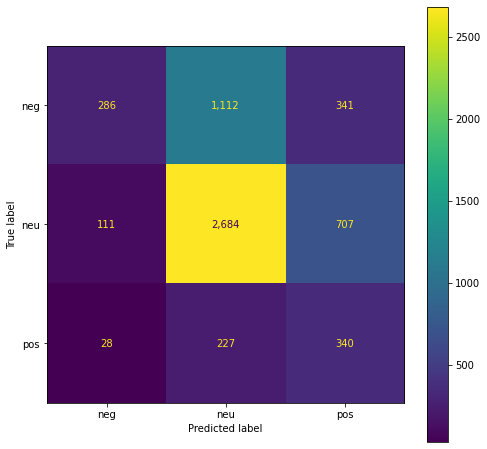

In [ ]:
showConfisionMatrix(simple_analysis["label"], simple_analysis["predict"])

# Training and Testing Dataset

แบ่งข้อมูลออกเป็นชุดฝึกฝน (Training Dataset) และชุดทดสอบ (Testing Dataset)

In [10]:
X = df["tokenize"]
y = df['Overview sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)
y_train.value_counts()

neu    490
neg    377
pos    357
Name: Overview sentiment, dtype: int64

# Generating Bag of Words

สร้าง Bag of Words เพื่อนับจำนวนคำแต่ละคำที่เกิดขึ้นในแต่ละข้อความ (1 แถวข้อมูล = 1 ข้อความ)

โดยจำนวนของคำทั้งหมดที่เกิดขึ้นในชุดข้อมูลฝึกฝน จะถูกนำมาใช้เป็น feature ในการฝึกฝนแบบจำลอง

In [11]:
count_vector = CountVectorizer(analyzer=lambda x:x.split('|'))
X_train = count_vector.fit_transform(X_train)
X_test = count_vector.transform(X_test)

# Naive Bays Classification

เรียกใช้ function สำหรับสร้างแบบจำลอง Multinomial Naive Bays จาก Library Sci-Ket Learn (sklearn) สำหรับงานแยกกลุ่มข้อมูล (ในที่นี้คือแยกข้อความที่มีว่าเป็น class ใด pos neg หรือ neu)

In [12]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)
predictions = naive_bayes.predict(X_test)
predictions

array(['pos', 'pos', 'neu', 'neu', 'neg', 'pos', 'pos', 'neg', 'pos',
       'pos', 'neg', 'pos', 'pos', 'neu', 'neu', 'neu', 'pos', 'neu',
       'pos', 'pos', 'neu', 'neg', 'neg', 'neu', 'neu', 'pos', 'pos',
       'neu', 'neu', 'neg', 'neu', 'neu', 'neg', 'pos', 'neg', 'neu',
       'neg', 'neu', 'neu', 'pos', 'pos', 'neu', 'neu', 'neu', 'neu',
       'pos', 'neu', 'neu', 'neu', 'neg', 'pos', 'neg', 'neu', 'neu',
       'neu', 'pos', 'pos', 'pos', 'neu', 'pos', 'neg', 'pos', 'neg',
       'neu', 'neg', 'neu', 'neu', 'neu', 'neu', 'pos', 'neu', 'neg',
       'pos', 'neg', 'neg', 'neg', 'neg', 'neu', 'neg', 'neg', 'neu',
       'neu', 'neg', 'neu', 'neg', 'pos', 'neu', 'neu', 'neg', 'pos',
       'neu', 'neg', 'neu', 'pos', 'neg', 'pos', 'neu', 'neu', 'pos',
       'neu', 'neu', 'neg', 'pos', 'neg', 'neu', 'pos', 'neu', 'pos',
       'pos', 'neu', 'neu', 'neu', 'neu', 'neg', 'pos', 'neu', 'neg',
       'neg', 'neg', 'neu', 'neg', 'pos', 'neu', 'neg', 'pos', 'pos',
       'neg', 'neg',

ตรวจสอบประสิทธิภาพแบบจำลอง Naive Bays

พบว่ามี Accuracy Score = 0.7568

In [13]:
ac1 = accuracy_score(y_test, predictions)

Accuracy score: 0.5830


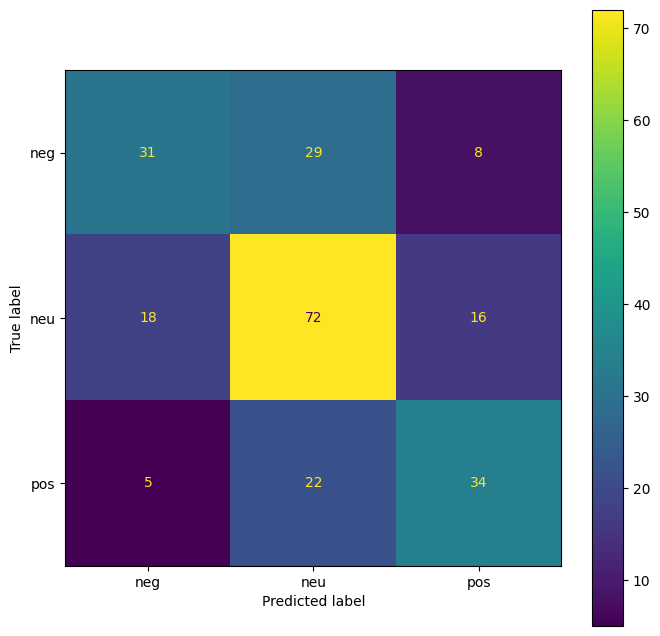

In [43]:
showConfisionMatrix(y_test, predictions)

# Logistic Regression Classification

เรียกใช้ function สำหรับสร้างแบบจำลอง Logistic Regression จาก Library sklearn

โดยใช้ feature เดียวกับกับที่ใช้แบบจำลอง Naive Bays

In [14]:
lr = LogisticRegression(max_iter=5000)
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
predictions

array(['pos', 'neu', 'neu', 'neu', 'neg', 'pos', 'neg', 'neg', 'neu',
       'pos', 'neu', 'pos', 'pos', 'neu', 'neu', 'neu', 'pos', 'neu',
       'neu', 'neu', 'neu', 'neg', 'neg', 'pos', 'neu', 'pos', 'neg',
       'neu', 'neu', 'neg', 'neu', 'neu', 'neg', 'pos', 'neg', 'neg',
       'neg', 'neu', 'neg', 'pos', 'pos', 'neg', 'neu', 'neu', 'neu',
       'neg', 'neu', 'neu', 'neu', 'neg', 'neu', 'neg', 'neu', 'neu',
       'neu', 'pos', 'pos', 'neu', 'neg', 'neg', 'neu', 'pos', 'neu',
       'neu', 'pos', 'pos', 'neu', 'neu', 'neg', 'pos', 'neu', 'neg',
       'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'pos',
       'neu', 'pos', 'neu', 'neu', 'pos', 'neg', 'neu', 'neg', 'pos',
       'neu', 'pos', 'neu', 'neg', 'neg', 'pos', 'neu', 'neu', 'pos',
       'neu', 'pos', 'neg', 'pos', 'neg', 'neu', 'pos', 'neu', 'neu',
       'pos', 'neu', 'neu', 'neu', 'neu', 'neu', 'pos', 'neu', 'neg',
       'neg', 'neg', 'neu', 'neu', 'neu', 'neu', 'neg', 'pos', 'neu',
       'neg', 'neu',

พบว่า แบบจำลอง Logistic Regression มี Accuracy Score = 0.7654 สูงกว่า Naive Bays เล็กน้อย

In [15]:
ac2 = accuracy_score(y_test, predictions)

Accuracy score: 0.6170


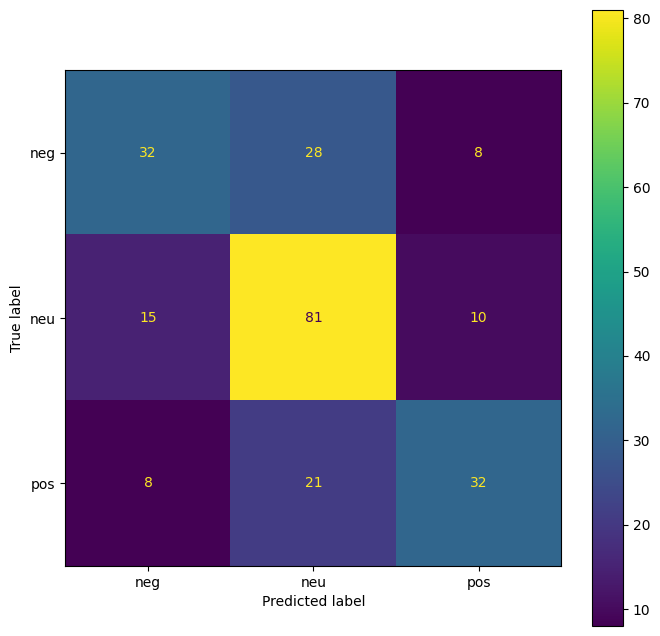

In [46]:
showConfisionMatrix(y_test, predictions)

# Support Vector Machine Classification

In [16]:
svm = svm.SVC()
svm.fit(X_train, y_train)
predictions = svm.predict(X_test)
predictions

array(['pos', 'neu', 'neu', 'neu', 'neu', 'pos', 'pos', 'neg', 'neu',
       'neg', 'neg', 'pos', 'pos', 'neu', 'neg', 'neg', 'pos', 'neu',
       'neu', 'neu', 'neu', 'neu', 'neg', 'pos', 'neu', 'pos', 'neg',
       'neu', 'neu', 'neg', 'neu', 'neu', 'neg', 'neg', 'neg', 'neu',
       'neg', 'neu', 'neu', 'pos', 'neu', 'neg', 'neu', 'neg', 'neu',
       'neg', 'neu', 'neu', 'neu', 'neg', 'neu', 'neg', 'neu', 'neu',
       'neg', 'neu', 'pos', 'neu', 'neg', 'pos', 'neg', 'pos', 'neu',
       'neu', 'neg', 'neg', 'neu', 'neu', 'neg', 'pos', 'neu', 'neg',
       'neg', 'neg', 'neg', 'neg', 'pos', 'neg', 'neg', 'neg', 'pos',
       'neu', 'neu', 'neu', 'neu', 'pos', 'neu', 'neu', 'neg', 'neu',
       'neu', 'neg', 'neu', 'pos', 'neg', 'pos', 'neu', 'neu', 'pos',
       'neg', 'pos', 'neg', 'pos', 'neu', 'neu', 'neu', 'neu', 'neu',
       'pos', 'neu', 'neu', 'neu', 'neu', 'neg', 'neg', 'neu', 'neg',
       'neg', 'neg', 'neu', 'neu', 'neu', 'neu', 'neg', 'neg', 'neg',
       'neu', 'neg',

In [17]:
ac3 = accuracy_score(y_test, predictions)

Accuracy score: 0.5872


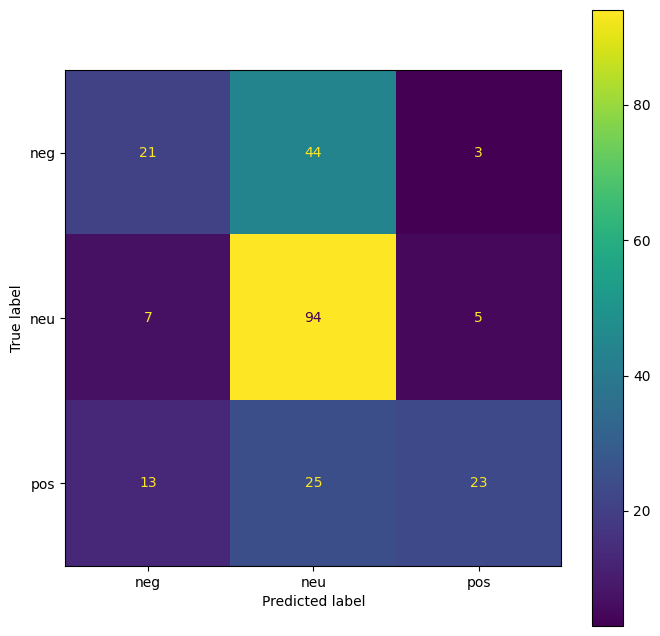

In [51]:
showConfisionMatrix(y_test, predictions)

In [18]:
model_score = [["Naive bayes",ac1],["LogisticRegression",ac2],["SVM",ac3]]
df_test = pd.DataFrame(model_score, columns=['Classfier','Accuracy_score'])

In [19]:
df_test = df_test.sort_values('Accuracy_score', ascending=False)
df_test

,Classfier,Accuracy_score
0,Naive bayes,0.611111
2,SVM,0.594771
1,LogisticRegression,0.584967


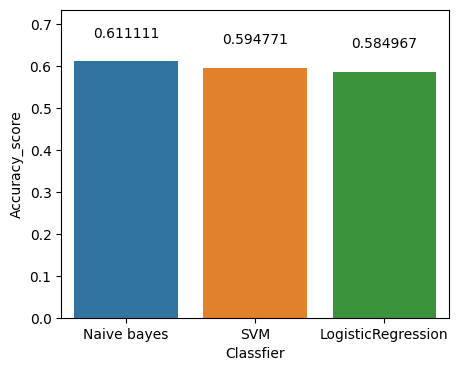

In [20]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5, 4))
barchart = sns.barplot(x=df_test['Classfier'], y=df_test['Accuracy_score'])
barchart.bar_label(ax.containers[0], label_type='edge', padding=15)
ax.margins(y=0.2)

# Improved Logistic Regression Classification

เพิ่ม 3 features คือ จำนวน positive polar word, จำนวน negative polar word, ความยาวประโยค

แบ่งชุดข้อมูลฝึกฝน และข้อมูลทดสอบ

In [ ]:
new_df = df.copy()
new_df["num_pos"] = pd.Series(map(count_polar_pos, new_df["tokenize"]), dtype='int32')
new_df["num_neg"] = pd.Series(map(count_polar_neg, new_df["tokenize"]), dtype='int32')

X = new_df["tokenize"]
y = new_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_test.value_counts()

neu    701
neg    348
pos    119
Name: label, dtype: int64

สร้าง Bag of Words แล้วนำมารวมกับ fetures ใหม่ที่สร้างไว้

In [ ]:
count_vector = CountVectorizer(analyzer=lambda x:x.split('|'))
train_idx = X_train.index
test_idx = X_test.index
X_train = count_vector.fit_transform(X_train)
X_test = count_vector.transform(X_test)

X_train = pd.DataFrame(X_train.toarray(), columns=count_vector.get_feature_names_out(), index=train_idx)
X_train = X_train.join(new_df[["num_pos", "num_neg"]])

X_test = pd.DataFrame(X_test.toarray(), columns=count_vector.get_feature_names_out(), index=test_idx)
X_test = X_test.join(new_df[["num_pos", "num_neg"]])

จากการเพิ่ม 2 features ใหม่

In [ ]:
new_lr = LogisticRegression()
new_lr.fit(X_train.values, y_train.values)
predictions = new_lr.predict(X_test.values)
predictions

array(['neg', 'neu', 'neu', ..., 'neu', 'neg', 'neg'], dtype=object)

ตรวจสอบประสิทธิภาพของแบบจำลอง Logistic Regression ที่มีการเพิ่ม features

พบว่า Accuracy Score เพิ่มขึ้นเป็น 0.7714

Accuracy score: 0.7714


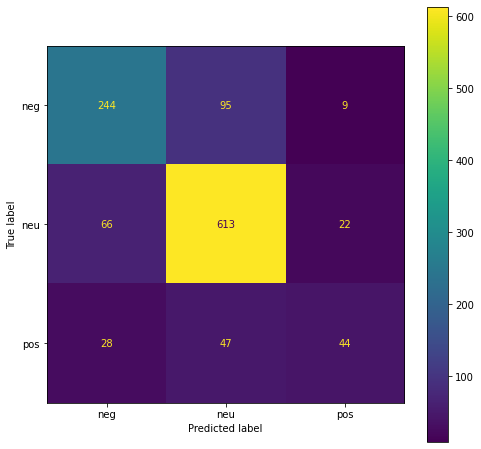

In [ ]:
showConfisionMatrix(y_test, predictions)

# Function to Predict

หากต้องการนำข้อความ ไปพยากรณ์โดยใช้แบบจำลองที่สร้างไว้ จำเป็นต้องแปลงข้อความให้อยู่ในรูปแบบ features ของแบบจำลองก่อน

*  ตัดคำ
*  แปลงเป็น Bag of Words
*  นำไปพยากรณ์ด้วย function predict()

In [ ]:
text = "พออ่านแล้วรู้สึกเซ็งอย่างแรง"
text_seg = text_cleansing(text)

text_seg

'อ่าน|รู้สึก|เซ็ง|แรง'

In [ ]:
text_features = count_vector.transform([text_seg])
text_features

<1x20791 sparse matrix of type '<class 'numpy.int64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [ ]:
nb_prediction = naive_bayes.predict(text_features)
nb_prediction

array(['neg'], dtype='<U3')

In [ ]:
lr_prediction = lr.predict(text_features)
lr_prediction

array(['neg'], dtype=object)

ในกรณีแบบจำลองที่ 3 ต้องเพิ่ม feature ใหม่ที่เป็นการนับคำเพิ่มเข้าไปด้วย

In [ ]:
import numpy as np
from scipy import sparse

p = count_polar_pos(text_seg)
n = count_polar_neg(text_seg)
add_fea = np.array([[p, n]])
text_features = sparse.hstack((text_features,add_fea))

text_features

<1x20793 sparse matrix of type '<class 'numpy.longlong'>'
	with 4 stored elements in COOrdinate format>

In [ ]:
lr_prediction = new_lr.predict(text_features)
lr_prediction

array(['neg'], dtype=object)

**Code it:** ทดลองเขียนเป็น function เพื่อทำนายขั้วความคิดเห็นของข้อความ โดยใช้แบบจำลอง Improved Logistic Regression

In [ ]:
def predictSentiment(text):
  # ==== Your Code Here ====
  text_seg = text_cleansing(text)
  text_features = count_vector.transform([text_seg])
  p = count_polar_pos(text_seg)
  n = count_polar_neg(text_seg)
  add_fea = np.array([[p, n]])
  text_features = sparse.hstack((text_features,add_fea))
  lr_prediction = new_lr.predict(text_features)
  if lr_prediction[0]=="pos":
    result = "บวก"
  elif lr_prediction[0]=="neg":
    result = "ลบ"
  else:
    result = "กลาง"

  print('จากข้อความ "{}" มีขั้วความคิดเห็นเป็น {}'.format(text, result))

In [ ]:
#text = "พออ่านแล้วรู้สึกเซ็งอย่างแรง"
text = input("กรอกประโยคที่ต้องการตรวจสอบ:")
print("="*15)
predictSentiment(text)

กรอกประโยคที่ต้องการตรวจสอบ:พออ่านแล้วรู้สึกเซ็งอย่างแรง
จากข้อความ "พออ่านแล้วรู้สึกเซ็งอย่างแรง" มีขั้วความคิดเห็นเป็น ลบ


# AI for Thai

สมัคร Account ได้ที่ https://aiforthai.in.th

เมื่อสมัครเรียบร้อยแล้ว สามารถ log-in เพื่อรับ API Key ได้ที่เมนู Profile

In [ ]:
import requests

url = "https://api.aiforthai.in.th/ssense"
text = df["sentence"][0]
params = {'text':text}
headers = {'Apikey': "_____________________"}
response = requests.get(url, headers=headers, params=params)

print(response.json())

{'sentiment': {'score': '100', 'polarity-neg': True, 'polarity-pos': True, 'polarity': 'negative'}, 'preprocess': {'input': 'เน็ตควายมากกูพูดจริงเสียดายตังค์ที่ติดตั้งเน็ตโครตห่วยยิ่งดึกๆเน็ตยิ่งห่วยตอนมาติดตั้งใหม่ๆก็ดีนานๆไปเเย่ขึ้นเรื่อยๆกากกว่าเน็ตค่ายอื่นอ่ะบอกจริงไม่สนหรอกว่าจะเป็นเด็กเเล้วเม้นด่าเเบบนี้ เเต่นี้หาตังค์จ่ายค่าเน็ตมาตลอดเหนื่อยน่ะเล่นเกมส์ไปเดี่ยวก็หายกากเกินติดตั้งโปรพิเศษ100Mเเต่พอวัดดูปล่อยไม่ถึงเท่าที่ตกลงกันไว้พอโทรไปเเจ้งก็ปล่อยมาเต็มไม่กี่วันก็เหมื่อนเดิมใบเเจ้งก็มาย้อนหลัง3เดือนทุกครั้งห่วยไปน่ะบางทีโปร100M/700 กว่าบาทเเต่คุณภาพเเย่เสียดายตังค์', 'neg': ['เสียดายตังค์', 'ห่วย', 'ห่วย', 'กาก', 'ด่า', 'เหนื่อย', 'หาย', 'กาก', 'ห่วย', 'เสียดายตังค์'], 'pos': ['ก็ดี', 'เย่', 'พิเศษ', 'คุณภาพ', 'เย่'], 'segmented': ['เน็ต', 'ควาย', 'มาก', 'กู', 'พูด', 'จริง', 'เสียดายตังค์', 'ที่', 'ติดตั้ง', 'เน็ต', 'โครต', 'ห่วย', 'ยิ่ง', 'ดึก', 'ๆ', 'เน็ต', 'ยิ่ง', 'ห่วย', 'ตอน', 'มา', 'ติดตั้ง', 'ใหม่', 'ๆ', 'ก็ดี', 'นานๆ', 'ไป', 'เย่', 'ขึ้น', 'เรื่อยๆ', 'กาก', 'กว่า', 'เน็

In [ ]:
result = dict(response.json())

print("Word Tokenize: {}".format(", ".join(result["preprocess"]["segmented"])))
print("Percent of intentions:")
for i in result["intention"]:
    print("\t{}: {}%".format(i, result["intention"][i]))

Word Tokenize: เน็ต, ควาย, มาก, กู, พูด, จริง, เสียดายตังค์, ที่, ติดตั้ง, เน็ต, โครต, ห่วย, ยิ่ง, ดึก, ๆ, เน็ต, ยิ่ง, ห่วย, ตอน, มา, ติดตั้ง, ใหม่, ๆ, ก็ดี, นานๆ, ไป, เย่, ขึ้น, เรื่อยๆ, กาก, กว่า, เน็ต, ค่าย, อื่น, อ่ะ, บอก, จริง, ไม่สน, หรอก, ว่าจะ, เป็น, เด็ก, เล้ว, เม้น, ด่า, เ, บบ, นี้,  , เต่, นี้, หา, ตังค์, จ่าย, ค่า, เน็ต, มาต, ลอด, เหนื่อย, น่ะ, เล่น, เกมส์, ไป, เดี่ยว, ก็, หาย, กาก, เกิน, ติดตั้ง, โปร, พิเศษ, 100, M, เต่, พอ, วัด, ดู, ปล่อย, ไม่ถึง, เท่าที่, ตกลง, กัน, ไว้, พอ, โทร, ไป, เจ้, งก็, ปล่อย, มา, เต็ม, ไม่, กี่, วัน, ก็, เห, มื่อ, น, เดิม, ใบ, เจ้, งก็, มา, ย้อนหลัง, 3, เดือน, ทุกครั้ง, ห่วย, ไป, น่ะ, บางที, โปร, 100, M, /, 700,  , กว่า, บาท, เต่, คุณภาพ, เย่, เสียดายตังค์
Percent of intentions:
	request: 0%
	sentiment: 100%
	question: 75%
	announcement: 0%


In [ ]:
print("Polarity: {}".format(result["sentiment"]["polarity"]))
print("Positive words: {}".format(", ".join(result["preprocess"]["pos"])))
print("Negative words: {}".format(", ".join(result["preprocess"]["neg"])))

Polarity: negative
Positive words: ก็ดี, เย่, พิเศษ, คุณภาพ, เย่
Negative words: เสียดายตังค์, ห่วย, ห่วย, กาก, ด่า, เหนื่อย, หาย, กาก, ห่วย, เสียดายตังค์


In [6]:
from pythainlp.tag import pos_tag

words = ['ไอโฟน','14','ดี','มั้ย']
pos_tag(words)

[('ไอโฟน', 'NCMN'), ('14', 'DCNM'), ('ดี', 'VATT'), ('มั้ย', 'ADVN')]